In [1]:
# Add Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import (adjusted_rand_score, silhouette_score,
                             davies_bouldin_score, calinski_harabasz_score)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist
from itertools import product
import gower

In [2]:
dataset_path = "./../datasets"

iris_dataset_path = dataset_path + "/iris.csv"                                         
ai_global_index_path = dataset_path + "/AI_index_db.csv"
global_earthquake_data_path = dataset_path + "/earthquakes.csv"

iris_df = pd.read_csv(iris_dataset_path)
ai_global_index_df = pd.read_csv(ai_global_index_path)
global_earthquake_data_df = pd.read_csv(global_earthquake_data_path)

global_earthquake_data_df = global_earthquake_data_df.dropna()  # Optional: drop rows with missing values
global_earthquake_data_df_numeric =global_earthquake_data_df.select_dtypes(include=[np.number])  # Keep only numeric columns

datasets = {
    
    "iris": pd.read_csv(iris_dataset_path),
    "ai_global_index": pd.read_csv(ai_global_index_path),
    "global_earthquake": global_earthquake_data_df_numeric
    
}


In [3]:
import warnings
warnings.filterwarnings('ignore')

### Affinity Based Algorithm Implementation (Based on our Algorithm - see report/Part-1.pdf)

In [4]:
def affinity_propagation(S, damping=0.5, preference=None, max_iter=200, convergence_iter=15):
    """
    Custom Affinity Propagation implementation with full parameter support.
    
    Args:
        S: Similarity matrix (precomputed, shape [n_samples, n_samples])
        damping: Damping factor (0.5-1.0), same as sklearn's 'damping'
        preference: Preference for exemplars (if None, uses median(S) like sklearn)
        max_iter: Maximum iterations
        convergence_iter: Early stopping if no change
        
    Returns:
        Dictionary of {exemplar_index: [list_of_member_indices]}
    """
    n = S.shape[0]
    
    # Set preference (like sklearn's default)
    if preference is None:
        preference = np.median(S)
    
    # Initialize diagonal of S with preferences
    np.fill_diagonal(S, preference)
    
    # Initialize messages
    R = np.zeros((n, n))  # Responsibilities
    A = np.zeros((n, n))  # Availabilities
    
    exemplars_prev = np.zeros(n, dtype=int)
    stable_count = 0
    
    for iteration in range(max_iter):
        # ===== Responsibilities Update =====
        # Compute AS = A + S (for stability)
        AS = A + S
        
        # Find max values (excluding diagonal)
        max_indices = np.argmax(AS, axis=1)
        max_values = AS[np.arange(n), max_indices]
        
        # Set max values to -inf for secondary max calculation
        AS_copy = AS.copy()
        AS_copy[np.arange(n), max_indices] = -np.inf
        secondary_max = np.max(AS_copy, axis=1)
        
        # Update responsibilities with damping
        R_new = S - max_values[:, np.newaxis]
        R_new[np.arange(n), max_indices] = S[np.arange(n), max_indices] - secondary_max
        R = damping * R + (1 - damping) * R_new
        
        # ===== Availabilities Update =====
        # Compute positive responsibilities
        Rp = np.maximum(R, 0)
        np.fill_diagonal(Rp, R.diagonal())  # Keep self-responsibility
        
        # Update availabilities with damping
        A_new = np.sum(Rp, axis=0) - Rp
        A_new = np.minimum(A_new, 0)
        
        # Self-availability update
        A_new.flat[::n+1] = np.sum(Rp, axis=0) - np.diag(Rp)
        
        A = damping * A + (1 - damping) * A_new
        
        # ===== Convergence Check =====
        current_exemplars = np.argmax(A + R, axis=1)
        if np.array_equal(current_exemplars, exemplars_prev):
            stable_count += 1
            if stable_count >= convergence_iter:
                break
        else:
            stable_count = 0
            
        exemplars_prev = current_exemplars
    
    # ===== Cluster Assignment =====
    exemplars = np.unique(current_exemplars)
    clusters = {e: [] for e in exemplars}
    
    for i in range(n):
        clusters[current_exemplars[i]].append(i)
    
    return clusters

In [5]:

def find_optimum_metrics(datasets):
    results = {}

    for name, df in datasets.items():
        print(f"\n=== Processing {name} dataset ===")
        df = df.dropna()

        use_gower = name == "ai_global_index"

        # Compute features
        if use_gower:
            # Gower Distance → Similarity
            distance_matrix = gower.gower_matrix(df)
            similarity_matrix = 1 - distance_matrix
            X = similarity_matrix  # Use this directly in AffinityPropagation
        else:
            # Use StandardScaler + numeric columns
            X_raw = df.select_dtypes(include=[np.number])
            X = StandardScaler().fit_transform(X_raw)

        similarity_values = X[np.triu_indices_from(X, k=1)]
        median_sim = np.median(similarity_values)
        min_sim = np.min(similarity_values)
        max_sim = np.max(similarity_values)

        # Try values around the median and min similarity to vary cluster granularity
        param_grid = {
            'damping': [0.5, 0.7, 0.9],
            'preference': [min_sim - 0.1, median_sim - 0.05, median_sim, median_sim + 0.05]
        }


        best_params = None
        best_metrics = {
            'Silhouette Score': -1,
            'Davies-Bouldin Index': float('inf'),
            'Calinski-Harabasz Index': -1,
            'n_clusters': 0
        }

        for damping, preference in product(param_grid['damping'], param_grid['preference']):
            print(f"\nTesting damping={damping}, preference={preference}")

            try:
                ap = AffinityPropagation(
                    damping=damping,
                    preference=preference,
                    affinity='precomputed' if use_gower else 'euclidean',
                    random_state=42
                )
                labels = ap.fit_predict(X)

                # Handle noise points (label = -1)
                unique_labels = set(labels)
                n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

                if n_clusters < 2:
                    print(f"Only {n_clusters} clusters formed - skipping")
                    continue

                print(f"Formed {n_clusters} clusters")

                # For metrics, we always need the original feature matrix (not similarity)
                X_for_metrics = X if not use_gower else StandardScaler().fit_transform(df.select_dtypes(include=[np.number]))

                metrics = {
                    'Silhouette Score': silhouette_score(X_for_metrics, labels),
                    'Davies-Bouldin Index': davies_bouldin_score(X_for_metrics, labels),
                    'Calinski-Harabasz Index': calinski_harabasz_score(X_for_metrics, labels),
                    'n_clusters': n_clusters
                }

                print("Current metrics:", {k: round(v, 4) if isinstance(v, float) else v
                                         for k, v in metrics.items()})

                if metrics['Silhouette Score'] > best_metrics['Silhouette Score']:
                    best_params = {'damping': damping, 'preference': preference}
                    best_metrics.update(metrics)
                    print("⭐ New best parameters found!")

            except Exception as e:
                print(f"❌ Clustering failed: {str(e)}")
                continue

        # Store and display final results
        results[name] = {
            'Best Parameters': best_params,
            'Best Metrics': best_metrics
        }

        print("\n=== Final Results ===")
        print(f"Dataset: {name}")
        print("Optimal Parameters:", best_params)
        print("Best Metrics:")
        for k, v in best_metrics.items():
            print(f"- {k}: {round(v, 4) if isinstance(v, float) else v}")
        print("=" * 50)

    return results


In [6]:
results = find_optimum_metrics({'ai_global_index': datasets.get('ai_global_index')})


=== Processing ai_global_index dataset ===

Testing damping=0.5, preference=-0.019700026512146
Formed 4 clusters
Current metrics: {'Silhouette Score': 0.0734, 'Davies-Bouldin Index': 1.619, 'Calinski-Harabasz Index': 13.924, 'n_clusters': 4}
⭐ New best parameters found!

Testing damping=0.5, preference=0.5883461952209472
Formed 11 clusters
Current metrics: {'Silhouette Score': -0.0281, 'Davies-Bouldin Index': 2.1118, 'Calinski-Harabasz Index': 14.4999, 'n_clusters': 11}

Testing damping=0.5, preference=0.6383461952209473
Formed 12 clusters
Current metrics: {'Silhouette Score': -0.0278, 'Davies-Bouldin Index': 1.845, 'Calinski-Harabasz Index': 14.5638, 'n_clusters': 12}

Testing damping=0.5, preference=0.6883461952209473
Formed 12 clusters
Current metrics: {'Silhouette Score': -0.0278, 'Davies-Bouldin Index': 1.845, 'Calinski-Harabasz Index': 14.5638, 'n_clusters': 12}

Testing damping=0.7, preference=-0.019700026512146
Formed 4 clusters
Current metrics: {'Silhouette Score': 0.0188, 'D

In [7]:
results = find_optimum_metrics({'iris': datasets.get('iris')})


=== Processing iris dataset ===

Testing damping=0.5, preference=-1.4412724047598315
Formed 19 clusters
Current metrics: {'Silhouette Score': 0.329, 'Davies-Bouldin Index': 0.8142, 'Calinski-Harabasz Index': 159.4134, 'n_clusters': 19}
⭐ New best parameters found!

Testing damping=0.5, preference=-1.3629767272601454
Formed 20 clusters
Current metrics: {'Silhouette Score': 0.3415, 'Davies-Bouldin Index': 0.8139, 'Calinski-Harabasz Index': 164.0706, 'n_clusters': 20}
⭐ New best parameters found!

Testing damping=0.5, preference=-1.3129767272601454
Formed 20 clusters
Current metrics: {'Silhouette Score': 0.3415, 'Davies-Bouldin Index': 0.8139, 'Calinski-Harabasz Index': 164.0706, 'n_clusters': 20}

Testing damping=0.5, preference=-1.2629767272601453
Formed 21 clusters
Current metrics: {'Silhouette Score': 0.344, 'Davies-Bouldin Index': 0.7983, 'Calinski-Harabasz Index': 161.5491, 'n_clusters': 21}
⭐ New best parameters found!

Testing damping=0.7, preference=-1.4412724047598315
Formed 19

In [8]:
results = find_optimum_metrics({'global_earthquake': datasets.get('global_earthquake')})


=== Processing global_earthquake dataset ===

Testing damping=0.5, preference=-4.10018951359841
Formed 34 clusters
Current metrics: {'Silhouette Score': 0.4966, 'Davies-Bouldin Index': 0.6678, 'Calinski-Harabasz Index': 26.1968, 'n_clusters': 34}
⭐ New best parameters found!

Testing damping=0.5, preference=-0.04653658438797877
Formed 30 clusters
Current metrics: {'Silhouette Score': 0.5522, 'Davies-Bouldin Index': 0.5171, 'Calinski-Harabasz Index': 23.1359, 'n_clusters': 30}
⭐ New best parameters found!

Testing damping=0.5, preference=0.003463415612021231
Formed 68 clusters
❌ Clustering failed: Number of labels is 68. Valid values are 2 to n_samples - 1 (inclusive)

Testing damping=0.5, preference=0.05346341561202123
Formed 68 clusters
❌ Clustering failed: Number of labels is 68. Valid values are 2 to n_samples - 1 (inclusive)

Testing damping=0.7, preference=-4.10018951359841
Formed 33 clusters
Current metrics: {'Silhouette Score': 0.4323, 'Davies-Bouldin Index': 0.6355, 'Calinski-

### Comparing custom base Affinity Algorithm implementation and SKlearns implementation


In [9]:
def compare_affinity_implementations(datasets, best_parameters):
    all_results = {}

    os.makedirs("./../results/cluster_plots", exist_ok=True)

    for name, df in datasets.items():
        print(f"\n{'='*50}\nProcessing dataset: {name}\n{'='*50}")
        df = df.dropna()

        # Parameters
        params = best_parameters.get(name, {})
        damping = params.get('damping', 0.5)
        preference = params.get('preference', None)
        print(f"Using parameters - Damping: {damping}, Preference: {preference}")

        use_gower = name == "ai_global_index"

        if use_gower:
            print("Using Gower distance...")
            distance_matrix = gower.gower_matrix(df)
            similarity_matrix = 1 - distance_matrix
            X = similarity_matrix
            X_plot = StandardScaler().fit_transform(df.select_dtypes(include=[np.number]))
        else:
            X_raw = df.select_dtypes(include=[np.number])
            X = StandardScaler().fit_transform(X_raw)
            X_plot = X

        # Preference
        if preference is None:
            if use_gower:
                similarity_values = X[np.triu_indices_from(X, k=1)]
                preference = np.median(similarity_values)
            else:
                preference = -np.median(pdist(X))**2 if len(X) > 1 else -1
            print(f"Computed preference: {preference:.4f}")

        results = {'Custom Affinity': {}, 'Sklearn Affinity': {}}

        # --- Custom ---
        try:
            print("\nRunning custom Affinity Propagation...")
            if use_gower:
                custom_clusters = affinity_propagation(X, damping=damping, preference=preference)
            else:
                distance_matrix = np.linalg.norm(X[:, None] - X[None, :], axis=2)
                similarity_matrix = -distance_matrix**2
                custom_clusters = affinity_propagation(similarity_matrix, damping=damping, preference=preference)

            custom_labels = np.zeros(len(X), dtype=int)
            for cluster_id, members in enumerate(custom_clusters.values()):
                for idx in members:
                    custom_labels[idx] = cluster_id

            n_custom_clusters = len(set(custom_labels))
            print(f"Custom AP created {n_custom_clusters} clusters")

            if n_custom_clusters < 2 or n_custom_clusters >= len(X):
                raise ValueError(f"Invalid cluster count: {n_custom_clusters}")

            results['Custom Affinity'] = {
                "ARI": None,
                "Silhouette": silhouette_score(X_plot, custom_labels),
                "DBI": davies_bouldin_score(X_plot, custom_labels),
                "CHI": calinski_harabasz_score(X_plot, custom_labels),
                "n_clusters": n_custom_clusters
            }

        except Exception as e:
            print(f"Custom AP failed: {str(e)}")
            custom_labels = None
            results['Custom Affinity'] = {
                "ARI": np.nan, "Silhouette": np.nan,
                "DBI": np.nan, "CHI": np.nan, "n_clusters": 0
            }

        # --- Sklearn ---
        try:
            print("\nRunning sklearn Affinity Propagation...")
            sklearn_ap = AffinityPropagation(
                affinity='precomputed' if use_gower else 'euclidean',
                damping=damping,
                preference=preference,
                random_state=42
            )
            sklearn_labels = sklearn_ap.fit_predict(X if not use_gower else similarity_matrix)

            n_sklearn_clusters = len(set(sklearn_labels))
            print(f"Sklearn AP created {n_sklearn_clusters} clusters")

            if n_sklearn_clusters < 2 or n_sklearn_clusters >= len(X):
                raise ValueError(f"Invalid cluster count: {n_sklearn_clusters}")

            results['Sklearn Affinity'] = {
                "ARI": adjusted_rand_score(sklearn_labels, custom_labels) if custom_labels is not None else np.nan,
                "Silhouette": silhouette_score(X_plot, sklearn_labels),
                "DBI": davies_bouldin_score(X_plot, sklearn_labels),
                "CHI": calinski_harabasz_score(X_plot, sklearn_labels),
                "n_clusters": n_sklearn_clusters
            }

            if custom_labels is not None:
                results['Custom Affinity']['ARI'] = adjusted_rand_score(sklearn_labels, custom_labels)

        except Exception as e:
            print(f"Sklearn AP failed: {str(e)}")
            results['Sklearn Affinity'] = {
                "ARI": np.nan, "Silhouette": np.nan,
                "DBI": np.nan, "CHI": np.nan, "n_clusters": 0
            }

        # --- Visualize Clusters ---
        try:
            reducer = PCA(n_components=2)
            X_2d = reducer.fit_transform(X_plot)

            plt.figure(figsize=(12, 5))
            
            # Custom
            if custom_labels is not None:
                plt.subplot(1, 2, 1)
                plt.scatter(X_2d[:, 0], X_2d[:, 1], c=custom_labels, cmap='tab20', s=20)
                plt.title(f"{name} - Custom Affinity Clusters")
                plt.xlabel("PC1")
                plt.ylabel("PC2")

            # Sklearn
            plt.subplot(1, 2, 2)
            plt.scatter(X_2d[:, 0], X_2d[:, 1], c=sklearn_labels, cmap='tab20', s=20)
            plt.title(f"{name} - Sklearn Affinity Clusters")
            plt.xlabel("PC1")
            plt.ylabel("PC2")

            plt.tight_layout()
            plt.savefig(f"./../results/images/{name}_Affinity.png")
            plt.show()
            plt.close()
            print(f"📸 Saved cluster plot: ./../results/images/{name}_Affinity.png")

        except Exception as e:
            print(f"❌ Plotting failed: {str(e)}")

        # Print metrics
        print("\nComparison Results:")
        for method in results:
            print(f"\n{method}:")
            for metric, value in results[method].items():
                if isinstance(value, float):
                    print(f"{metric:>12}: {value:.4f}")
                else:
                    print(f"{metric:>12}: {value}")

        all_results[name] = results

    # Save metrics
    results_df = pd.DataFrame.from_dict(
        {(dataset, method): metrics
         for dataset in all_results
         for method, metrics in all_results[dataset].items()},
        orient='index'
    )
    results_df.to_csv("./../results/affinity_comparison_metrics.csv")
    print("\n✅ Saved results to affinity_comparison_metrics.csv")

    return all_results



Processing dataset: iris
Using parameters - Damping: 0.5, Preference: -1.2629767272601453

Running custom Affinity Propagation...
Custom AP created 21 clusters

Running sklearn Affinity Propagation...
Sklearn AP created 21 clusters


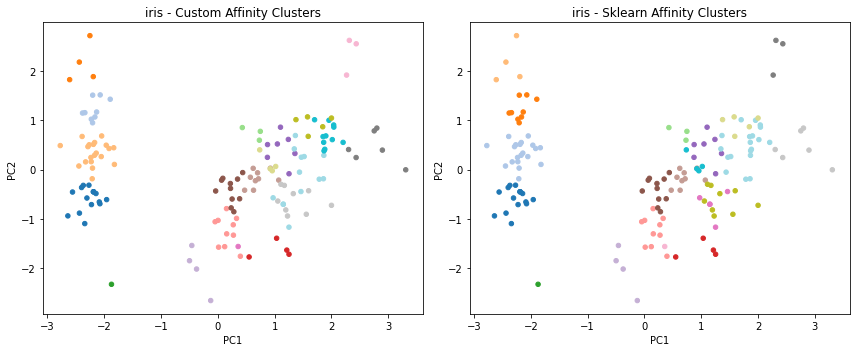

📸 Saved cluster plot: ./../results/images/iris_Affinity.png

Comparison Results:

Custom Affinity:
         ARI: 1.0000
  Silhouette: 0.3440
         DBI: 0.7983
         CHI: 161.5491
  n_clusters: 21

Sklearn Affinity:
         ARI: 1.0000
  Silhouette: 0.3440
         DBI: 0.7983
         CHI: 161.5491
  n_clusters: 21

Processing dataset: ai_global_index
Using parameters - Damping: 0.9, Preference: 0.58
Using Gower distance...

Running custom Affinity Propagation...
Custom AP created 11 clusters

Running sklearn Affinity Propagation...
Sklearn AP created 2 clusters


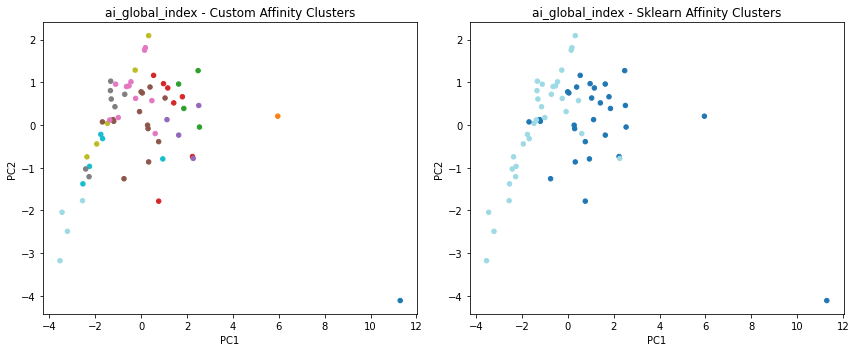

📸 Saved cluster plot: ./../results/images/ai_global_index_Affinity.png

Comparison Results:

Custom Affinity:
         ARI: 0.1896
  Silhouette: -0.0281
         DBI: 2.1118
         CHI: 14.4999
  n_clusters: 11

Sklearn Affinity:
         ARI: 0.1896
  Silhouette: 0.1678
         DBI: 1.6196
         CHI: 15.3613
  n_clusters: 2

Processing dataset: global_earthquake
Using parameters - Damping: 0.7, Preference: -10

Running custom Affinity Propagation...
Custom AP created 38 clusters

Running sklearn Affinity Propagation...
Sklearn AP created 29 clusters


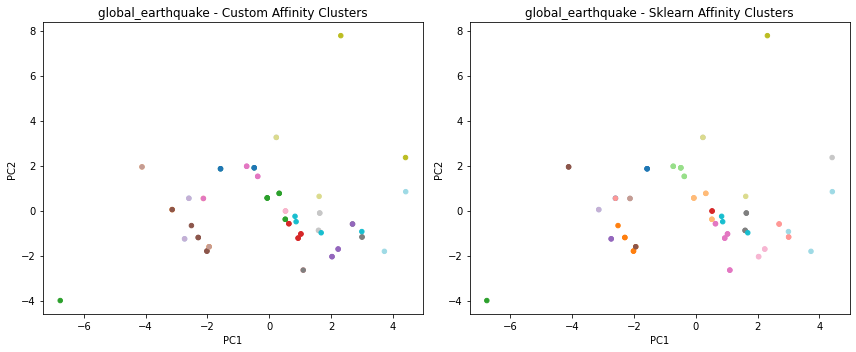

📸 Saved cluster plot: ./../results/images/global_earthquake_Affinity.png

Comparison Results:

Custom Affinity:
         ARI: 0.9143
  Silhouette: 0.1923
         DBI: 0.6038
         CHI: 19.6672
  n_clusters: 38

Sklearn Affinity:
         ARI: 0.9143
  Silhouette: 0.4777
         DBI: 0.5563
         CHI: 30.1187
  n_clusters: 29

✅ Saved results to affinity_comparison_metrics.csv


In [10]:
# Example Usage
if __name__ == "__main__":
    # Load your datasets
    
    # Define the best parameters for Affinity Propagation
    best_parameters = {
        'global_earthquake': {'damping': 0.7, 'preference': -10},
        'iris': {'damping': 0.5, 'preference': -1.2629767272601453},
        'ai_global_index': {'damping': 0.9, 'preference': 0.58}
        
    }

    # Compare implementations
    results = compare_affinity_implementations(datasets, best_parameters)